# Import Libraries and Dependencies
Import necessary data science libraries (NumPy, Pandas, Matplotlib) and the core backtesting framework components required for the strategy.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from bab_framework import (
    FundingDataBundle, 
    compute_sharpe,
    BettingAgainstBetaParams,
    BettingAgainstBetaStrategy,
    BettingAgainstBetaWeighting,
    BABWalkForwardRunner
)
from binance_data_loader import BinanceDataLoader

# Ensure plots are displayed inline
%matplotlib inline

# Define QuintileWeighting Class
Implement the `QuintileWeighting` class inheriting from `BettingAgainstBetaWeighting` (as base), which segments the asset universe into volume-based quintiles before applying weights.

In [2]:
class QuintileWeighting(BettingAgainstBetaWeighting):
    def __init__(self, target_quintile: int, n_quintiles: int = 5):
        self.target_quintile = target_quintile
        self.n_quintiles = n_quintiles
        
    def weights(self, idx, signals, bundle, universe_mask, params):
        # Retrieve volume row (using 30-day rolling avg volume which we load into 'volume_df')
        if bundle.volume_df is None:
            raise ValueError("Volume data is required for QuintileWeighting")
            
        current_date = bundle.dates[idx]
        if current_date not in bundle.volume_df.index:
             vol_row = np.zeros(len(bundle.tickers)) # Or handle gracefully
        else:
             vol_row = bundle.volume_df.loc[current_date].to_numpy()
             vol_row = np.nan_to_num(vol_row, 0.0)
        
        # STEP 1: Get ALL assets with finite/positive volume (before any other filtering)
        all_finite_vol_idx = np.where(vol_row > 0)[0] # Use > 0 for valid volume
        n_total = len(all_finite_vol_idx)
        
        if n_total < self.n_quintiles:
            return np.zeros(len(vol_row))
        
        # STEP 2: Sort by volume and split into quintiles
        # Sort Low -> High, so Q5 (index 4) = highest volume
        sorted_args = np.argsort(vol_row[all_finite_vol_idx])
        sorted_indices = all_finite_vol_idx[sorted_args]
        
        # np.array_split distributes remainder to first chunks
        chunks = np.array_split(sorted_indices, self.n_quintiles)
        quintile_indices = chunks[self.target_quintile]
        
        # STEP 3: NOW intersect with the validity mask (base filters)
        # This is equivalent to: mask[top_idx] = True; mask &= base
        quintile_mask = np.zeros(len(vol_row), dtype=bool)
        quintile_mask[quintile_indices] = True
        
        # Intersect with the existing universe mask (price exists, beta exists etc)
        final_mask = quintile_mask & universe_mask
        
        # Pass to parent weighting logic with the final filtered mask
        return super().weights(idx, signals, bundle, final_mask, params)

# Initialize Data Bundle and Strategy Parameters
Load the BAB data bundle and define the necessary simulation parameters, including start dates, end dates, and transaction costs.

In [3]:
# 1. Load Data
loader = BinanceDataLoader(
    data_directory="/Users/chinjieheng/Documents/data/binance_1Hdata",
    funding_rate_directory="/Users/chinjieheng/Documents/data/binance_fundingrate_data",
    timeframe='1h',
    min_records=90,
    min_volume=1e6,
    start_date="2023-01-01",
    end_date=None
)

price_hf = loader.get_price_matrix()
returns_df_hf = price_hf.pct_change()

# Prepare Daily Data
price_daily = price_hf.resample('D').last()
returns_daily = price_daily.pct_change()

# Process Funding Data
funding_long = loader.get_funding_long_form()
daily_funding = (
    funding_long['fundingRate']
    .unstack(level=0)
    .sort_index()
    .resample('D').sum(min_count=1)
)

# Get Volume Data (30d Rolling Mean)
daily_volume = loader.get_volume_matrix(vol_30d=True)
daily_volume = daily_volume.reindex(price_daily.index).fillna(0.0)

# Create Bundle
bundle = FundingDataBundle(
    price_df=price_daily,
    funding_df=daily_funding,
    returns_df=returns_daily,
    volume_df=daily_volume,
    returns_df_hf=returns_df_hf,
    hf_window_multiplier=24,
    min_hist_days=30,
    hf_resample_rule='D'
)

# 2. Define Base Parameters (Single Configuration for Quintile Analysis)
base_params = BettingAgainstBetaParams(
    beta_window=30,
    portfolio_size_each_side=100, # Reduced size since quintiles are smaller
    target_side_beta=1.0,
    beta_tolerance=0.001,
    gross_exposure_limit=1.0,
    leverage_cap=5.0,
    beta_type="btc",
    tc_bps=5,
    use_shrinkage=True,
    prior_beta_window=90,
    min_weight=0.0,
    max_weight=1.0,
    weighting_method="frazzini_pedersen",
    max_funding_short=0.1,
    min_funding_long=-0.1,
    volatility_scaling=True,
    volume_filter_threshold=0.0 # DISABLED here because QuintileWeighting handles filtering
)

Loading Binance data from /Users/chinjieheng/Documents/data/binance_1Hdata (timeframe=1h)...
Found 623 USDT trading pairs
Using a 720-bar rolling window for 30d volume checks
✓ BTCUSDT loaded successfully with 27105 records, avg volume: 636,432,576
Loaded 574 cryptocurrencies
Filtered 46 cryptocurrencies (insufficient data/volume)
Precomputing returns matrix (FAST numpy version)...
Building returns matrix (Memory Optimized)...
Matrix shape: (27105, 574)
Precomputed returns matrix shape: (27105, 574)
Date range: 2023-01-01 00:00:00 to 2026-02-03 08:00:00
Loading funding rate data from /Users/chinjieheng/Documents/data/binance_fundingrate_data...
Found 625 funding rate files
Loaded funding rates for 574 symbols


/var/folders/4j/50_b76mn3qj360c47nzkyxdc0000gn/T/ipykernel_98027/3551078671.py:13: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_df_hf = price_hf.pct_change()
/var/folders/4j/50_b76mn3qj360c47nzkyxdc0000gn/T/ipykernel_98027/3551078671.py:17: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_daily = price_daily.pct_change()


Building volume matrix (volume_30d) for 574 tickers over 27105 dates...


# Backtest Quintile Strategies
Run a loop to instantiate the `QuintileWeighting` strategy for each quintile (0 to 4), execute the backtest for each, and store the resulting performance statistics.


Running BAB for Liquidity Quintile 1/5 (Higher is more liquid)...
BAB Iteration 1 (Expanding): Train [0:90], Test [90:179]
Precomputing rolling betas (window=30)...
  -> Using High-Frequency Data (multiplier=24, resample=D)
Precomputing rolling betas (window=90)...
  -> Using High-Frequency Data (multiplier=24, resample=D)
BAB Iteration 2 (Expanding): Train [0:180], Test [180:269]
BAB Iteration 3 (Expanding): Train [0:270], Test [270:359]
BAB Iteration 4 (Expanding): Train [0:360], Test [360:449]
BAB Iteration 5 (Expanding): Train [0:450], Test [450:539]
BAB Iteration 6 (Expanding): Train [0:540], Test [540:629]
BAB Iteration 7 (Expanding): Train [0:630], Test [630:719]
BAB Iteration 8 (Expanding): Train [0:720], Test [720:809]
BAB Iteration 9 (Expanding): Train [0:810], Test [810:899]
BAB Iteration 10 (Expanding): Train [0:900], Test [900:989]
BAB Iteration 11 (Expanding): Train [0:990], Test [990:1079]
BAB Iteration 12 (Expanding): Train [0:1080], Test [1080:1129]

--- Report for Qu

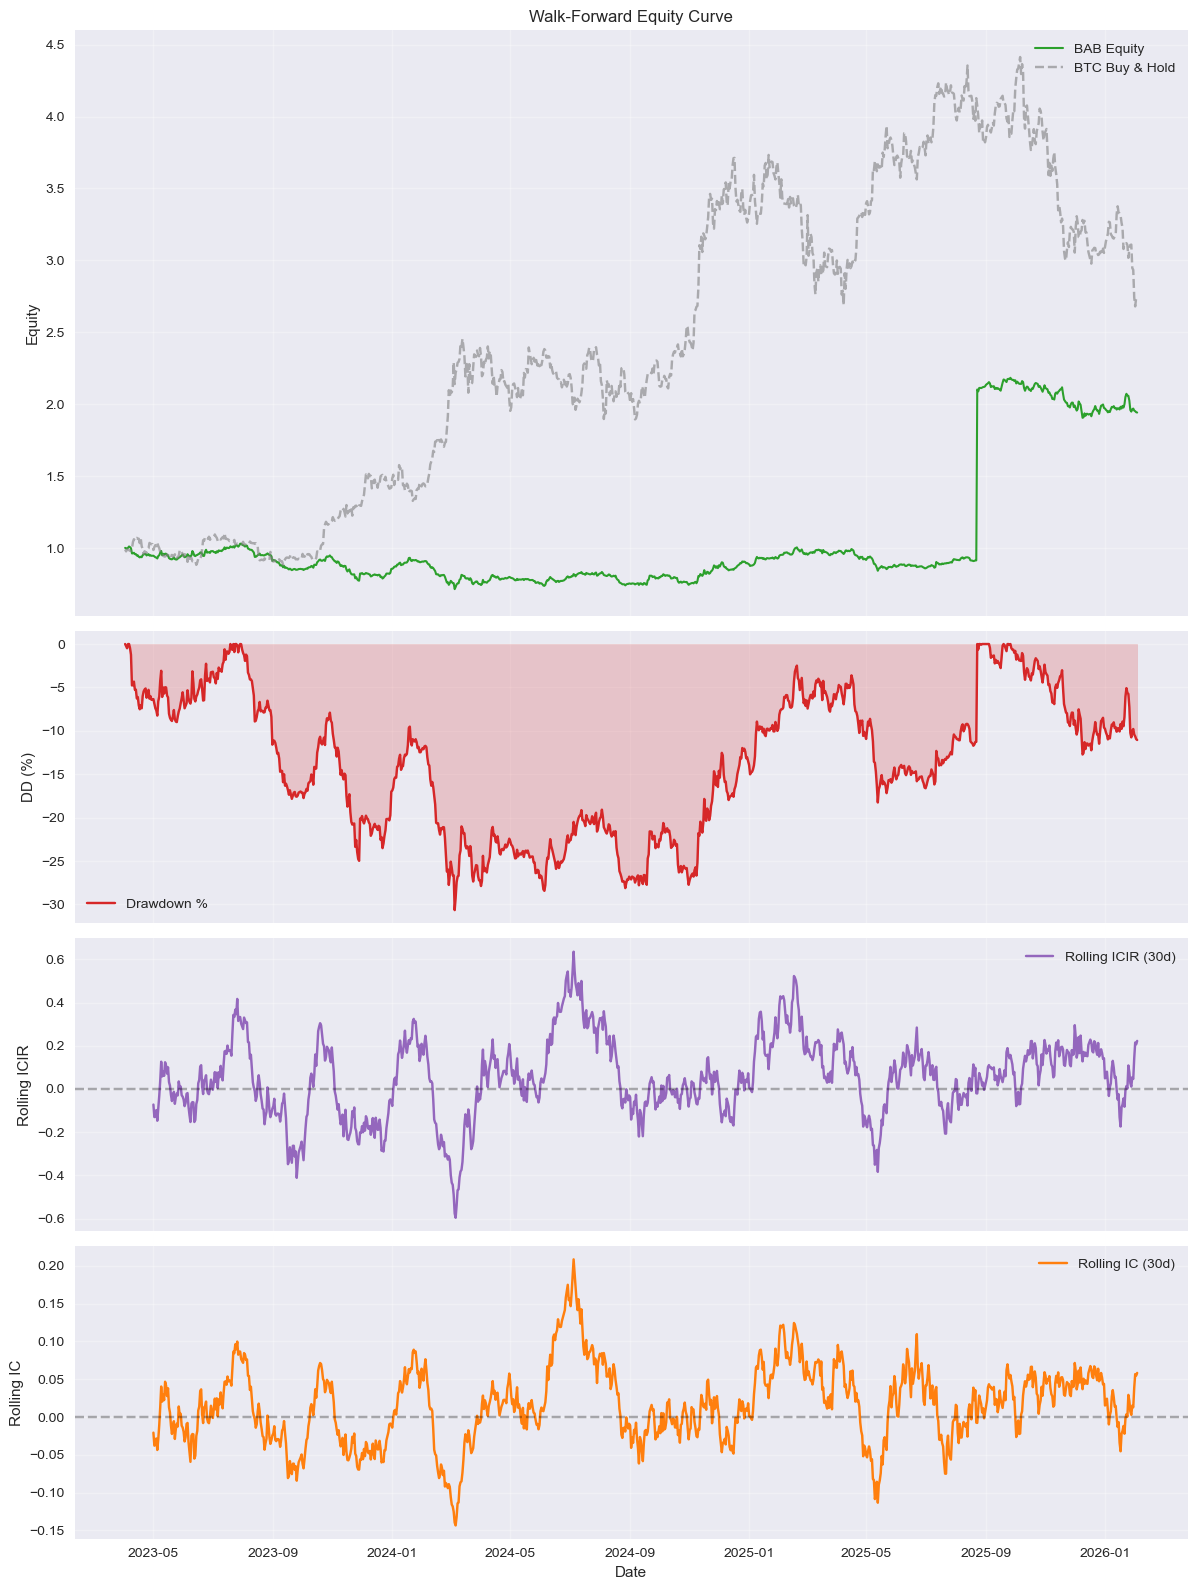

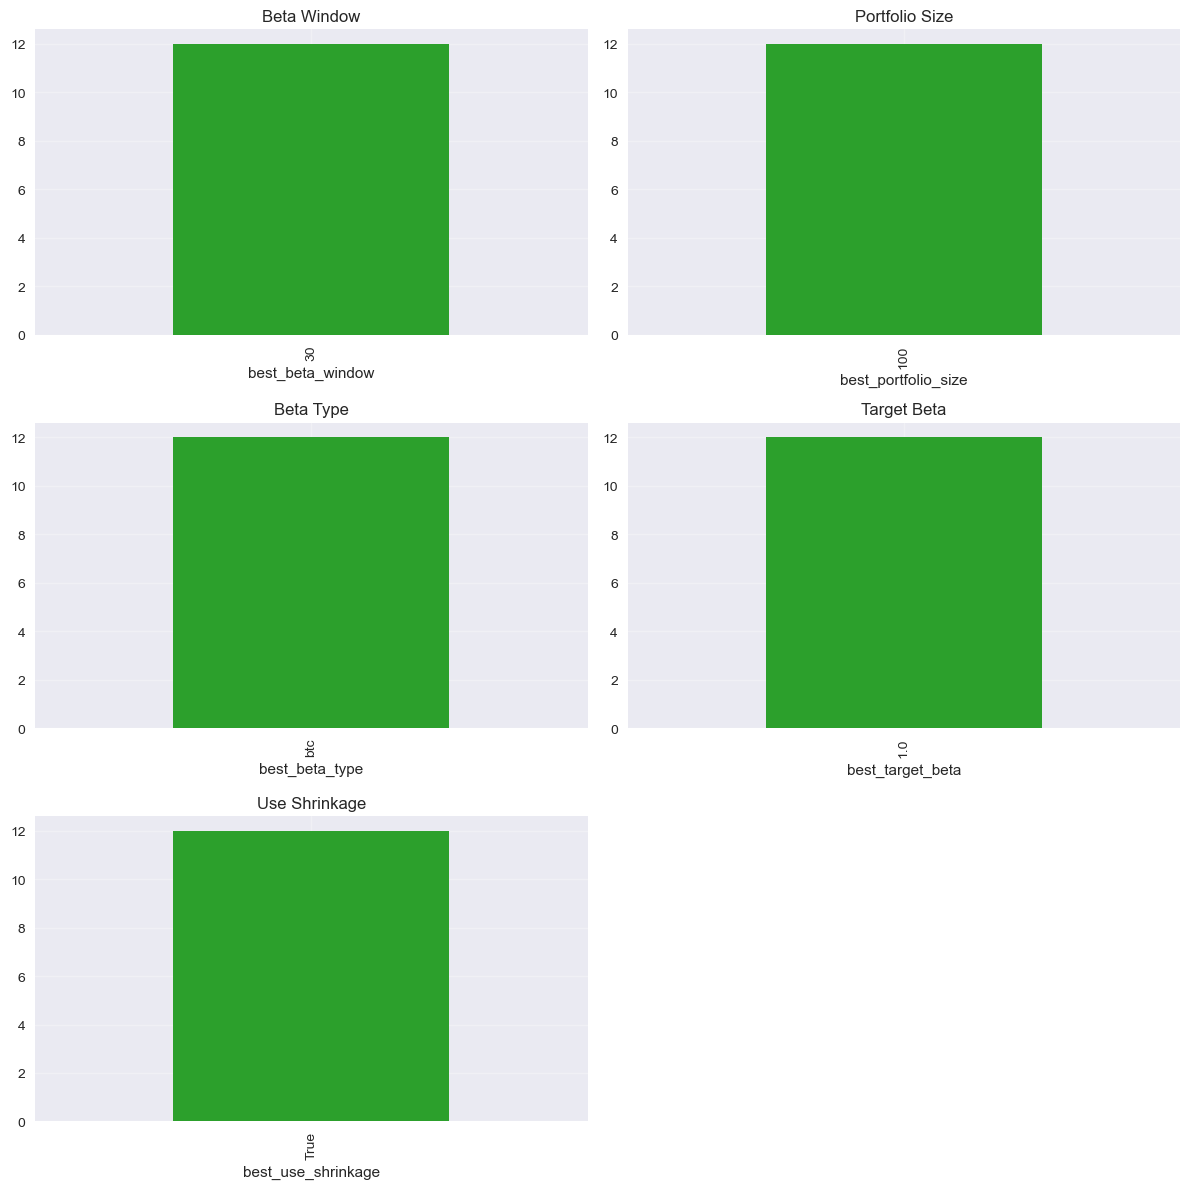

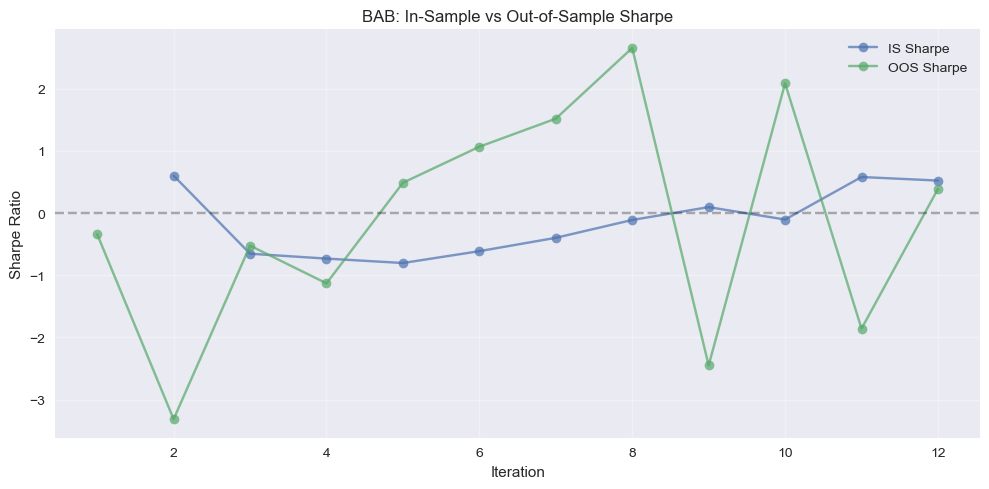


Running BAB for Liquidity Quintile 2/5 (Higher is more liquid)...
BAB Iteration 1 (Expanding): Train [0:90], Test [90:179]
BAB Iteration 2 (Expanding): Train [0:180], Test [180:269]
BAB Iteration 3 (Expanding): Train [0:270], Test [270:359]
BAB Iteration 4 (Expanding): Train [0:360], Test [360:449]
BAB Iteration 5 (Expanding): Train [0:450], Test [450:539]
BAB Iteration 6 (Expanding): Train [0:540], Test [540:629]
BAB Iteration 7 (Expanding): Train [0:630], Test [630:719]
BAB Iteration 8 (Expanding): Train [0:720], Test [720:809]
BAB Iteration 9 (Expanding): Train [0:810], Test [810:899]
BAB Iteration 10 (Expanding): Train [0:900], Test [900:989]
BAB Iteration 11 (Expanding): Train [0:990], Test [990:1079]
BAB Iteration 12 (Expanding): Train [0:1080], Test [1080:1129]

--- Report for Quintile 2 ---
AGGREGATED OUT-OF-SAMPLE PERFORMANCE (Betting Against Beta) (Quintile 2)
Mode: EXPANDING
Total OOS Bars: 1028
Date Range: 2023-04-02 to 2026-02-03
--- Risk-Adjusted ---
Selected Score (shar

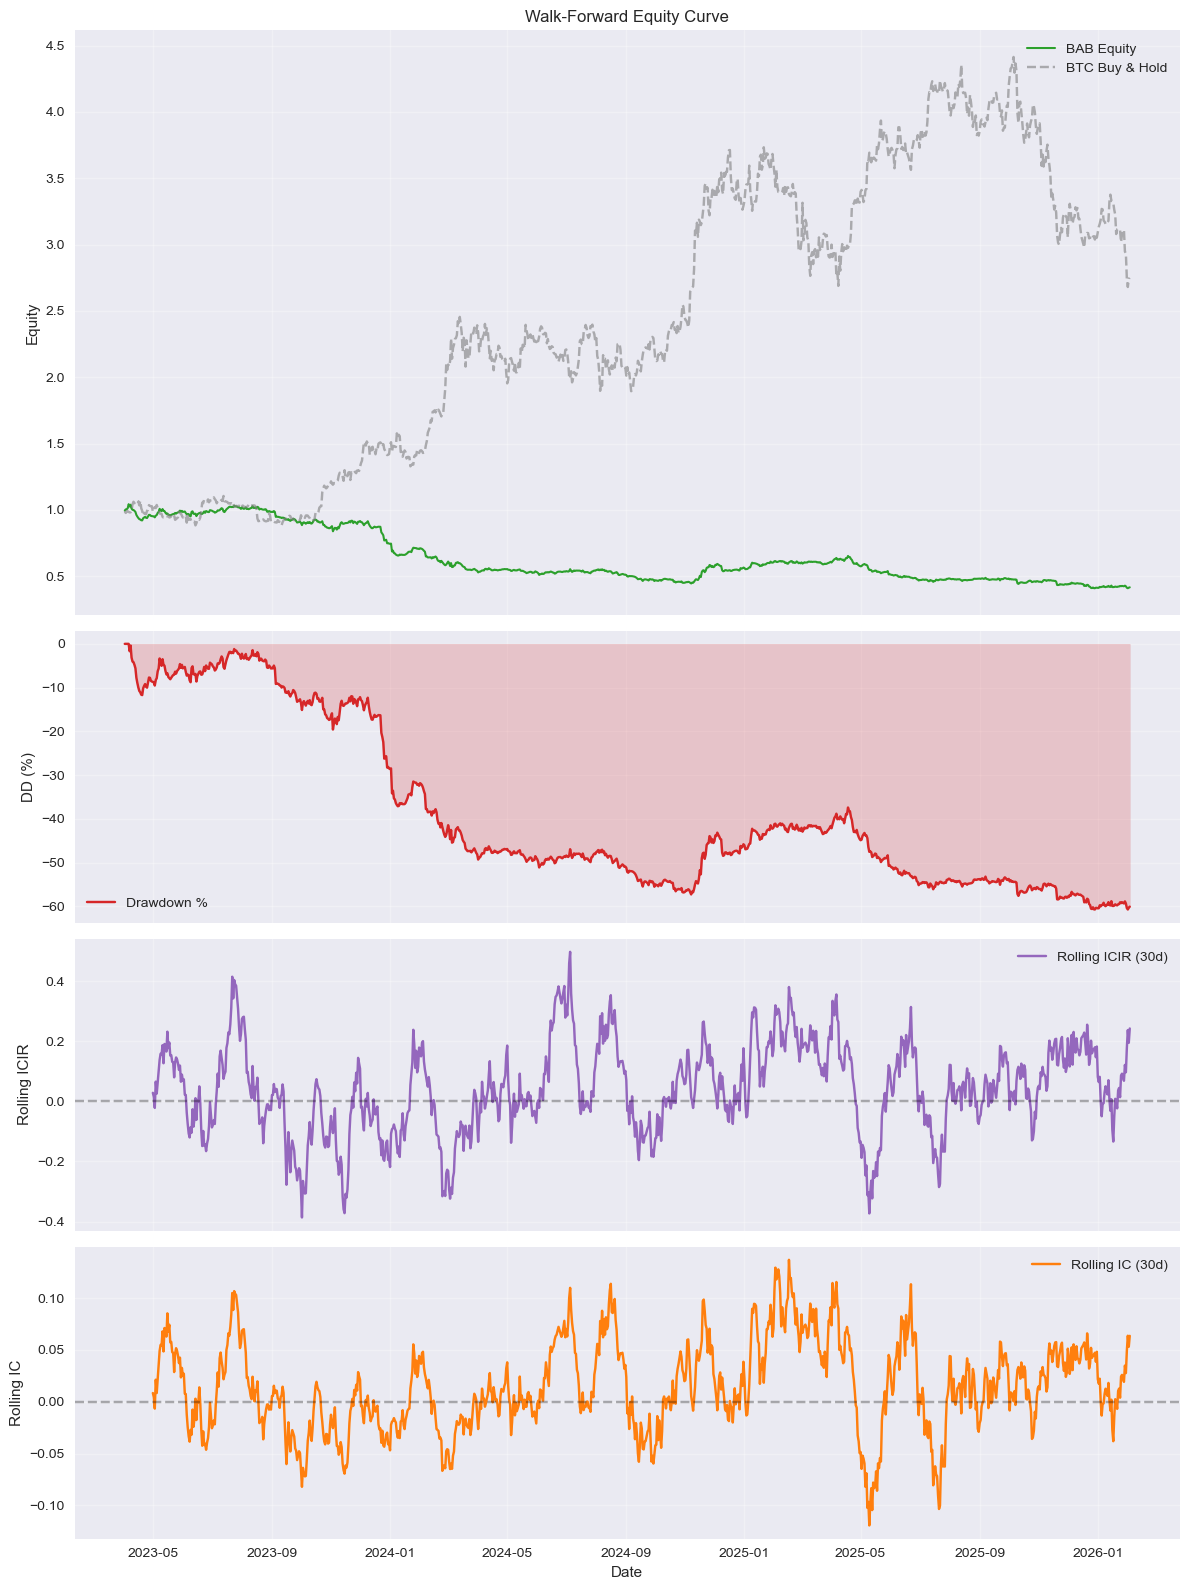

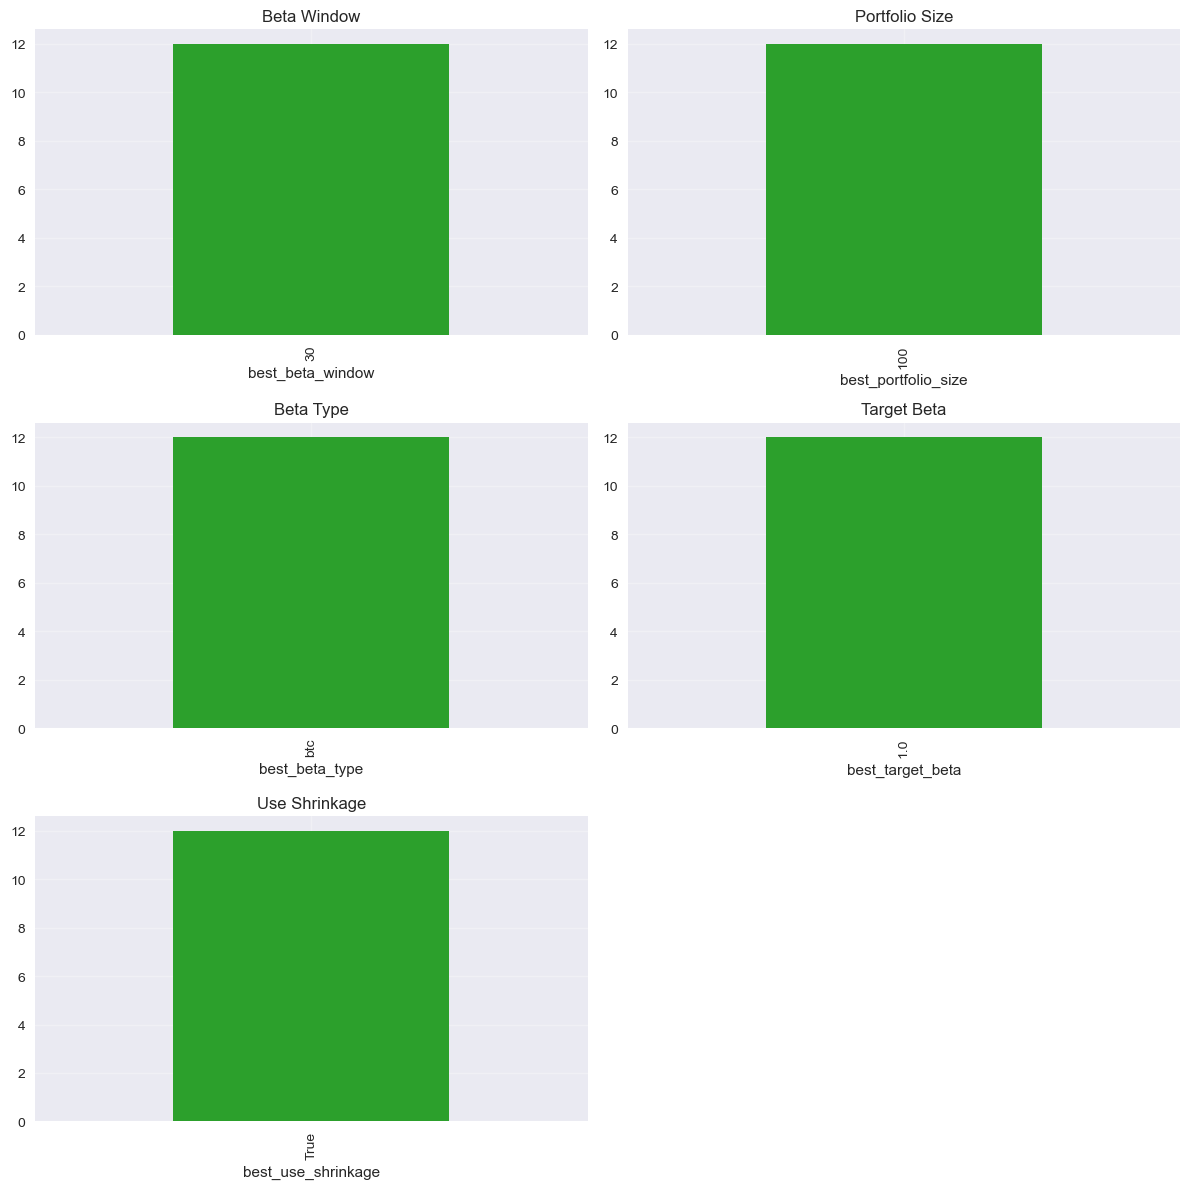

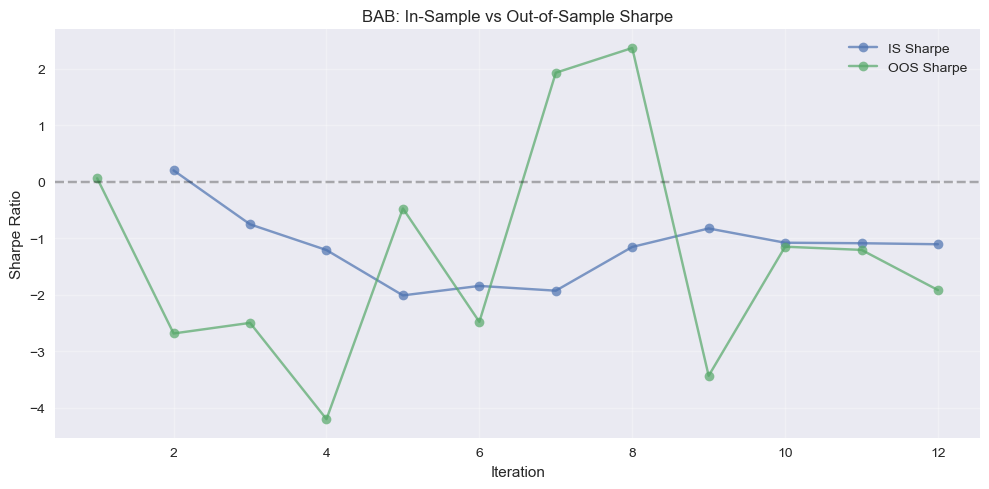


Running BAB for Liquidity Quintile 3/5 (Higher is more liquid)...
BAB Iteration 1 (Expanding): Train [0:90], Test [90:179]
BAB Iteration 2 (Expanding): Train [0:180], Test [180:269]
BAB Iteration 3 (Expanding): Train [0:270], Test [270:359]
BAB Iteration 4 (Expanding): Train [0:360], Test [360:449]
BAB Iteration 5 (Expanding): Train [0:450], Test [450:539]
BAB Iteration 6 (Expanding): Train [0:540], Test [540:629]
BAB Iteration 7 (Expanding): Train [0:630], Test [630:719]
BAB Iteration 8 (Expanding): Train [0:720], Test [720:809]
BAB Iteration 9 (Expanding): Train [0:810], Test [810:899]
BAB Iteration 10 (Expanding): Train [0:900], Test [900:989]
BAB Iteration 11 (Expanding): Train [0:990], Test [990:1079]
BAB Iteration 12 (Expanding): Train [0:1080], Test [1080:1129]

--- Report for Quintile 3 ---
AGGREGATED OUT-OF-SAMPLE PERFORMANCE (Betting Against Beta) (Quintile 3)
Mode: EXPANDING
Total OOS Bars: 1028
Date Range: 2023-04-02 to 2026-02-03
--- Risk-Adjusted ---
Selected Score (shar

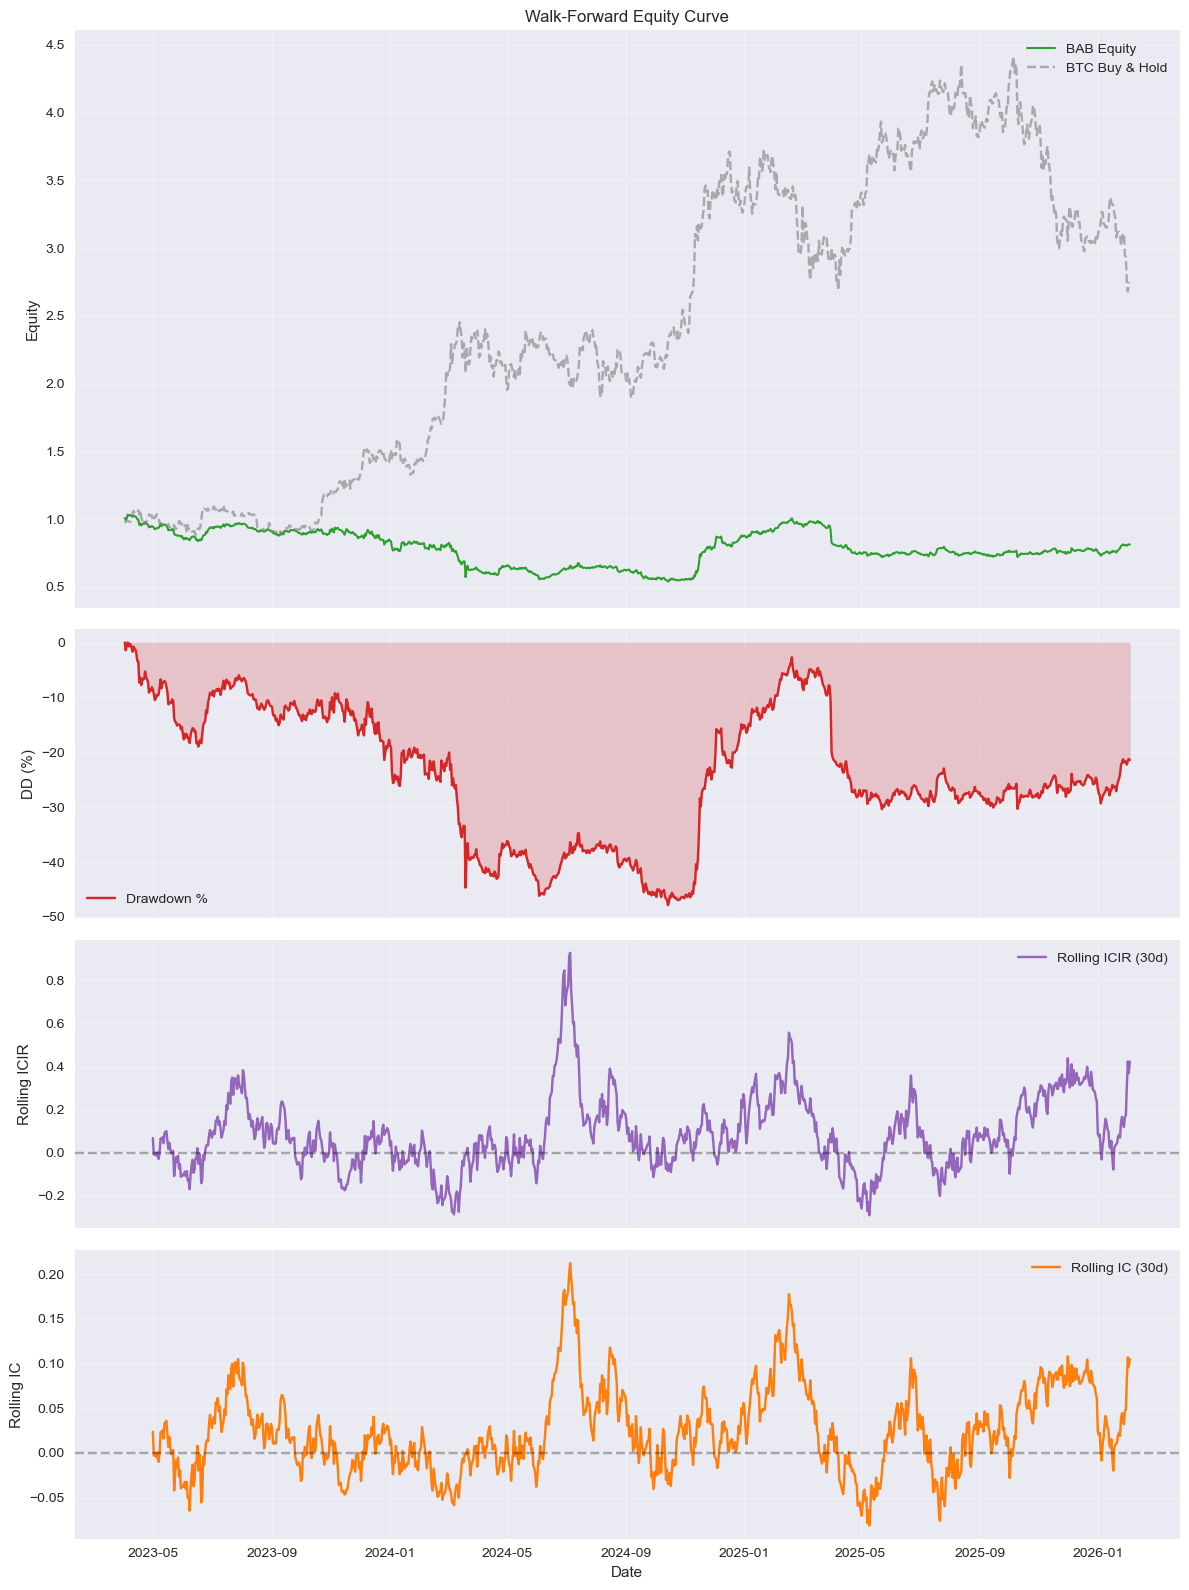

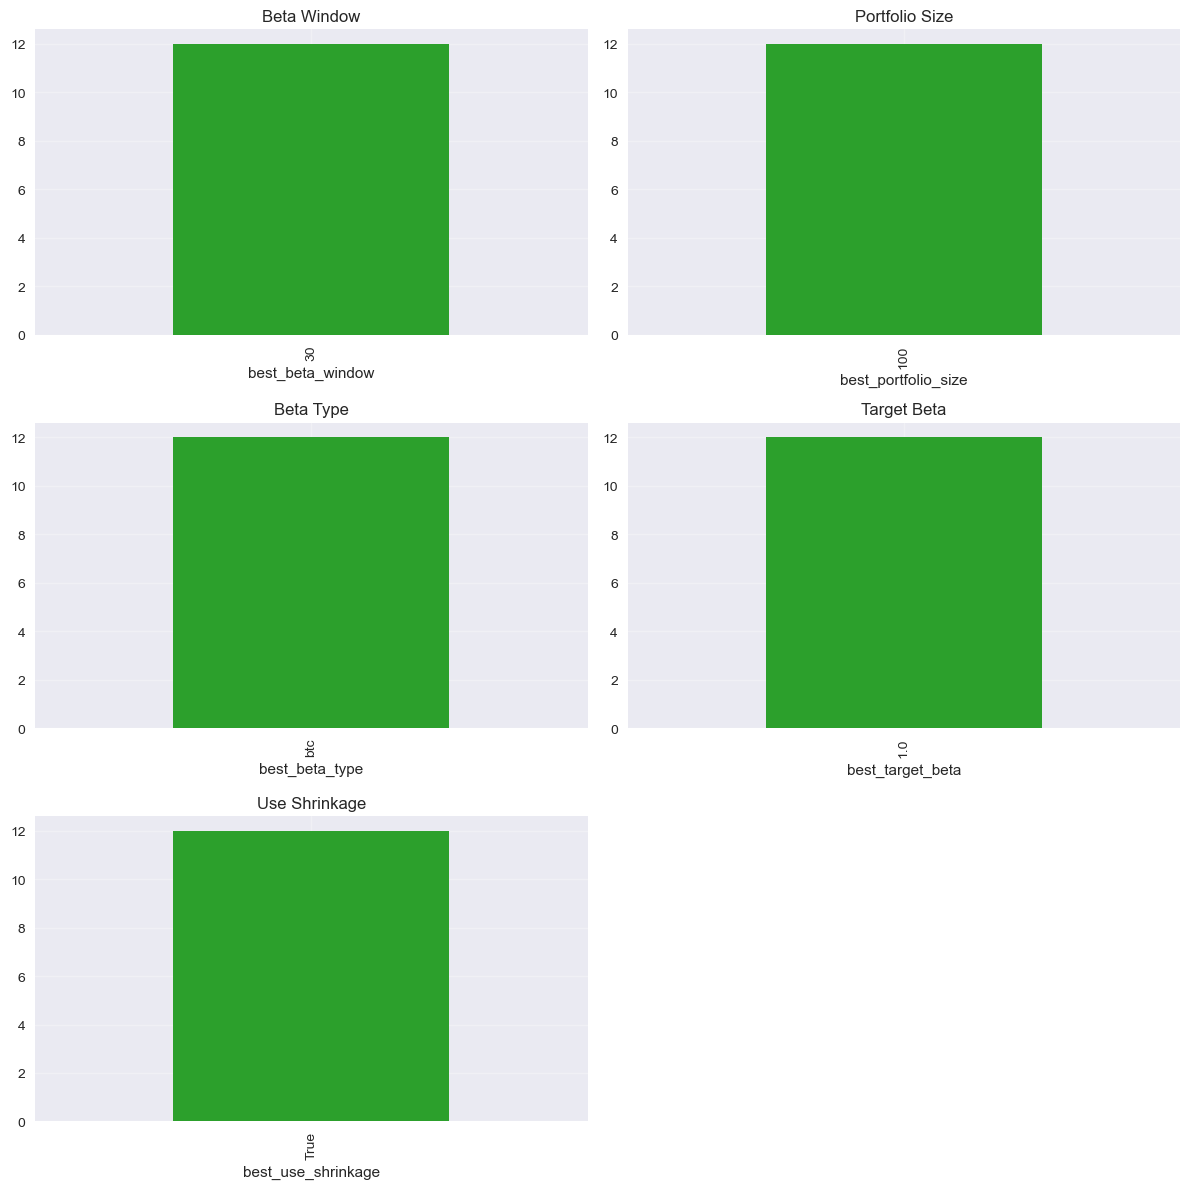

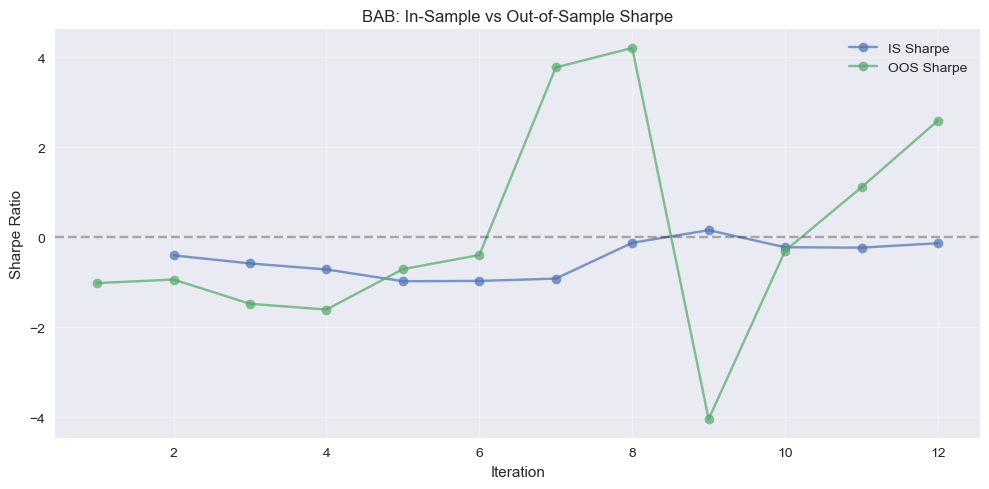


Running BAB for Liquidity Quintile 4/5 (Higher is more liquid)...
BAB Iteration 1 (Expanding): Train [0:90], Test [90:179]
BAB Iteration 2 (Expanding): Train [0:180], Test [180:269]
BAB Iteration 3 (Expanding): Train [0:270], Test [270:359]
BAB Iteration 4 (Expanding): Train [0:360], Test [360:449]
BAB Iteration 5 (Expanding): Train [0:450], Test [450:539]
BAB Iteration 6 (Expanding): Train [0:540], Test [540:629]
BAB Iteration 7 (Expanding): Train [0:630], Test [630:719]
BAB Iteration 8 (Expanding): Train [0:720], Test [720:809]
BAB Iteration 9 (Expanding): Train [0:810], Test [810:899]
BAB Iteration 10 (Expanding): Train [0:900], Test [900:989]
BAB Iteration 11 (Expanding): Train [0:990], Test [990:1079]
BAB Iteration 12 (Expanding): Train [0:1080], Test [1080:1129]

--- Report for Quintile 4 ---
AGGREGATED OUT-OF-SAMPLE PERFORMANCE (Betting Against Beta) (Quintile 4)
Mode: EXPANDING
Total OOS Bars: 1028
Date Range: 2023-04-02 to 2026-02-03
--- Risk-Adjusted ---
Selected Score (shar

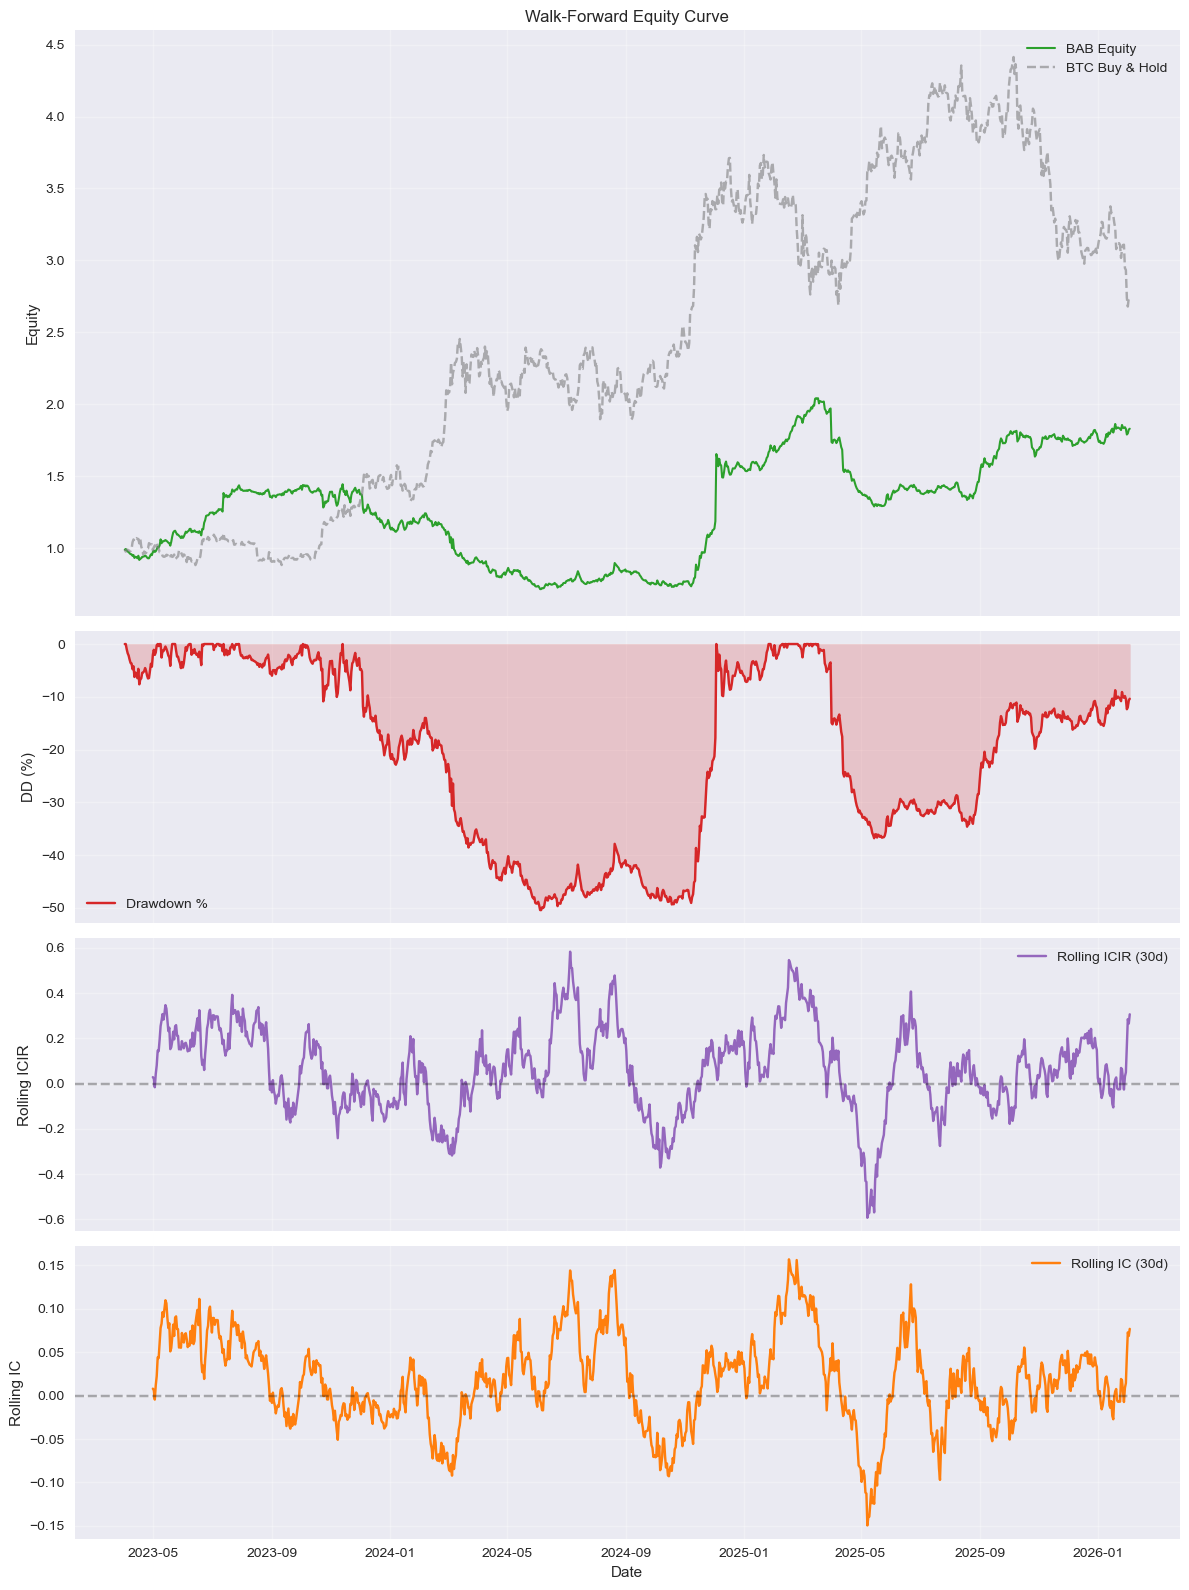

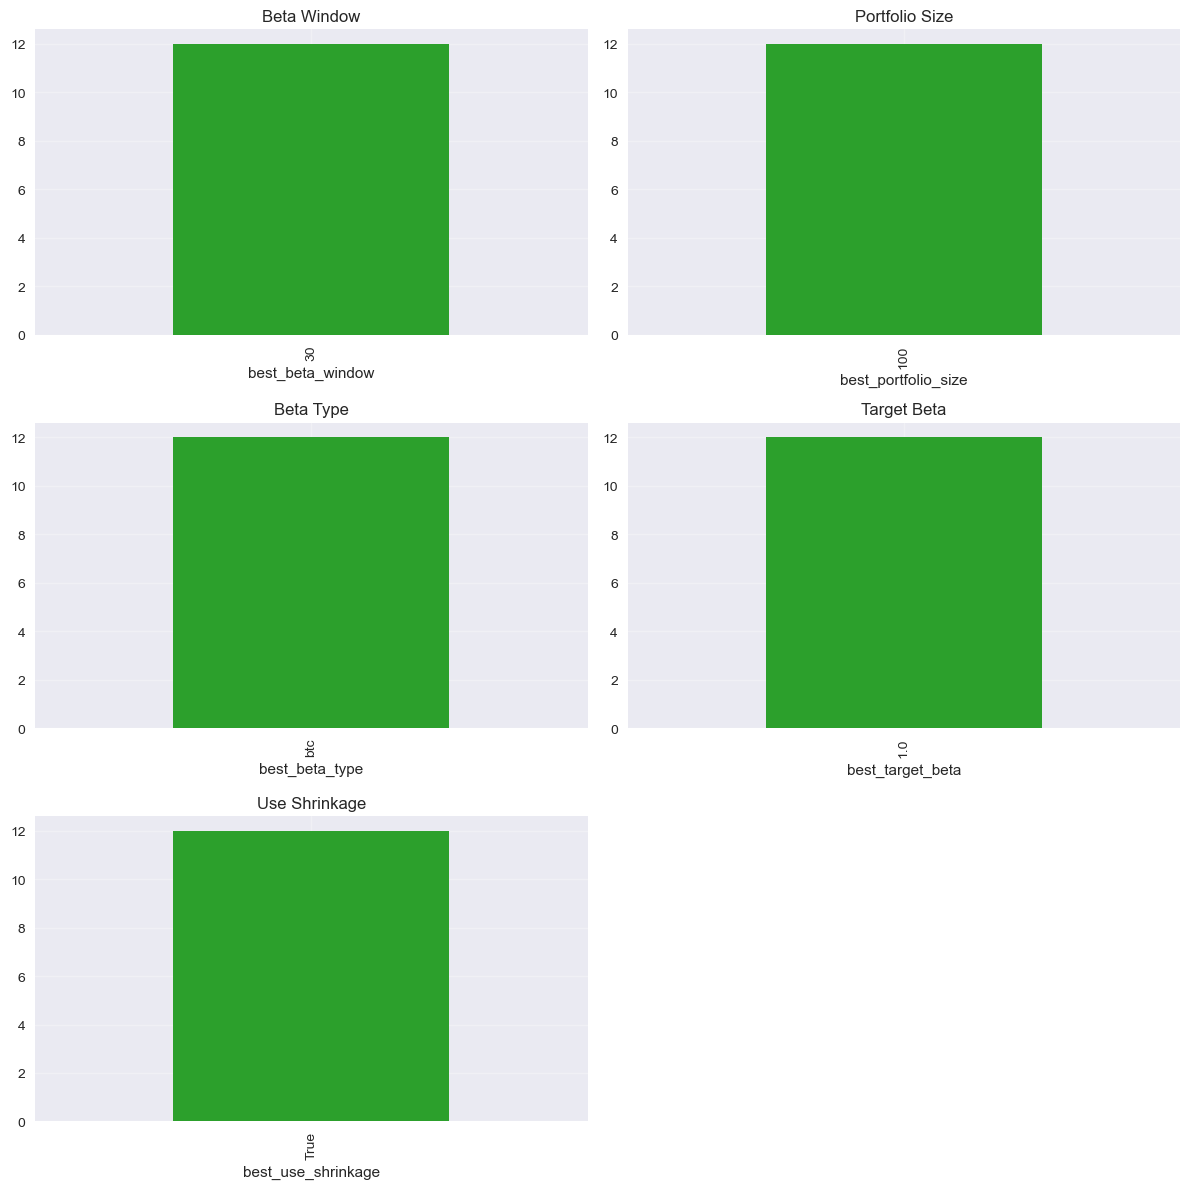

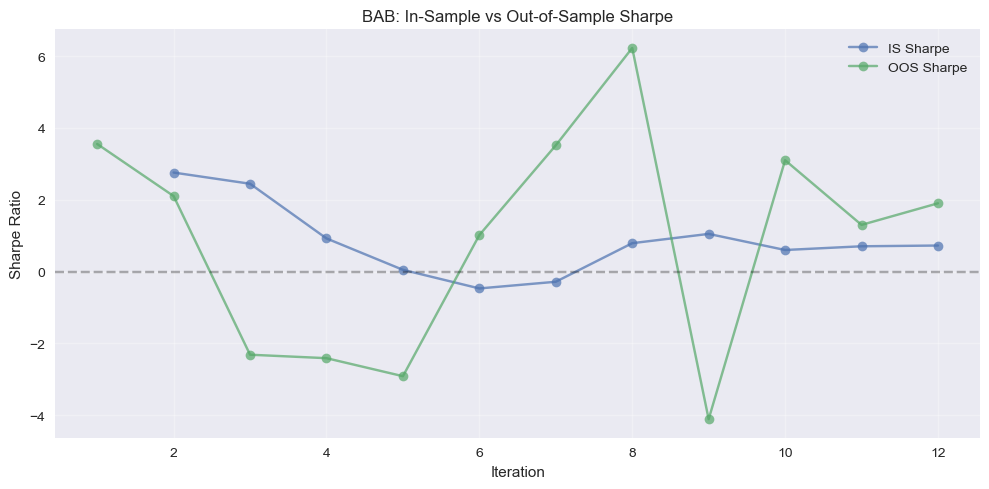


Running BAB for Liquidity Quintile 5/5 (Higher is more liquid)...
BAB Iteration 1 (Expanding): Train [0:90], Test [90:179]
BAB Iteration 2 (Expanding): Train [0:180], Test [180:269]
BAB Iteration 3 (Expanding): Train [0:270], Test [270:359]
BAB Iteration 4 (Expanding): Train [0:360], Test [360:449]
BAB Iteration 5 (Expanding): Train [0:450], Test [450:539]
BAB Iteration 6 (Expanding): Train [0:540], Test [540:629]
BAB Iteration 7 (Expanding): Train [0:630], Test [630:719]
BAB Iteration 8 (Expanding): Train [0:720], Test [720:809]
BAB Iteration 9 (Expanding): Train [0:810], Test [810:899]
BAB Iteration 10 (Expanding): Train [0:900], Test [900:989]
BAB Iteration 11 (Expanding): Train [0:990], Test [990:1079]
BAB Iteration 12 (Expanding): Train [0:1080], Test [1080:1129]

--- Report for Quintile 5 ---
AGGREGATED OUT-OF-SAMPLE PERFORMANCE (Betting Against Beta) (Quintile 5)
Mode: EXPANDING
Total OOS Bars: 1028
Date Range: 2023-04-02 to 2026-02-03
--- Risk-Adjusted ---
Selected Score (shar

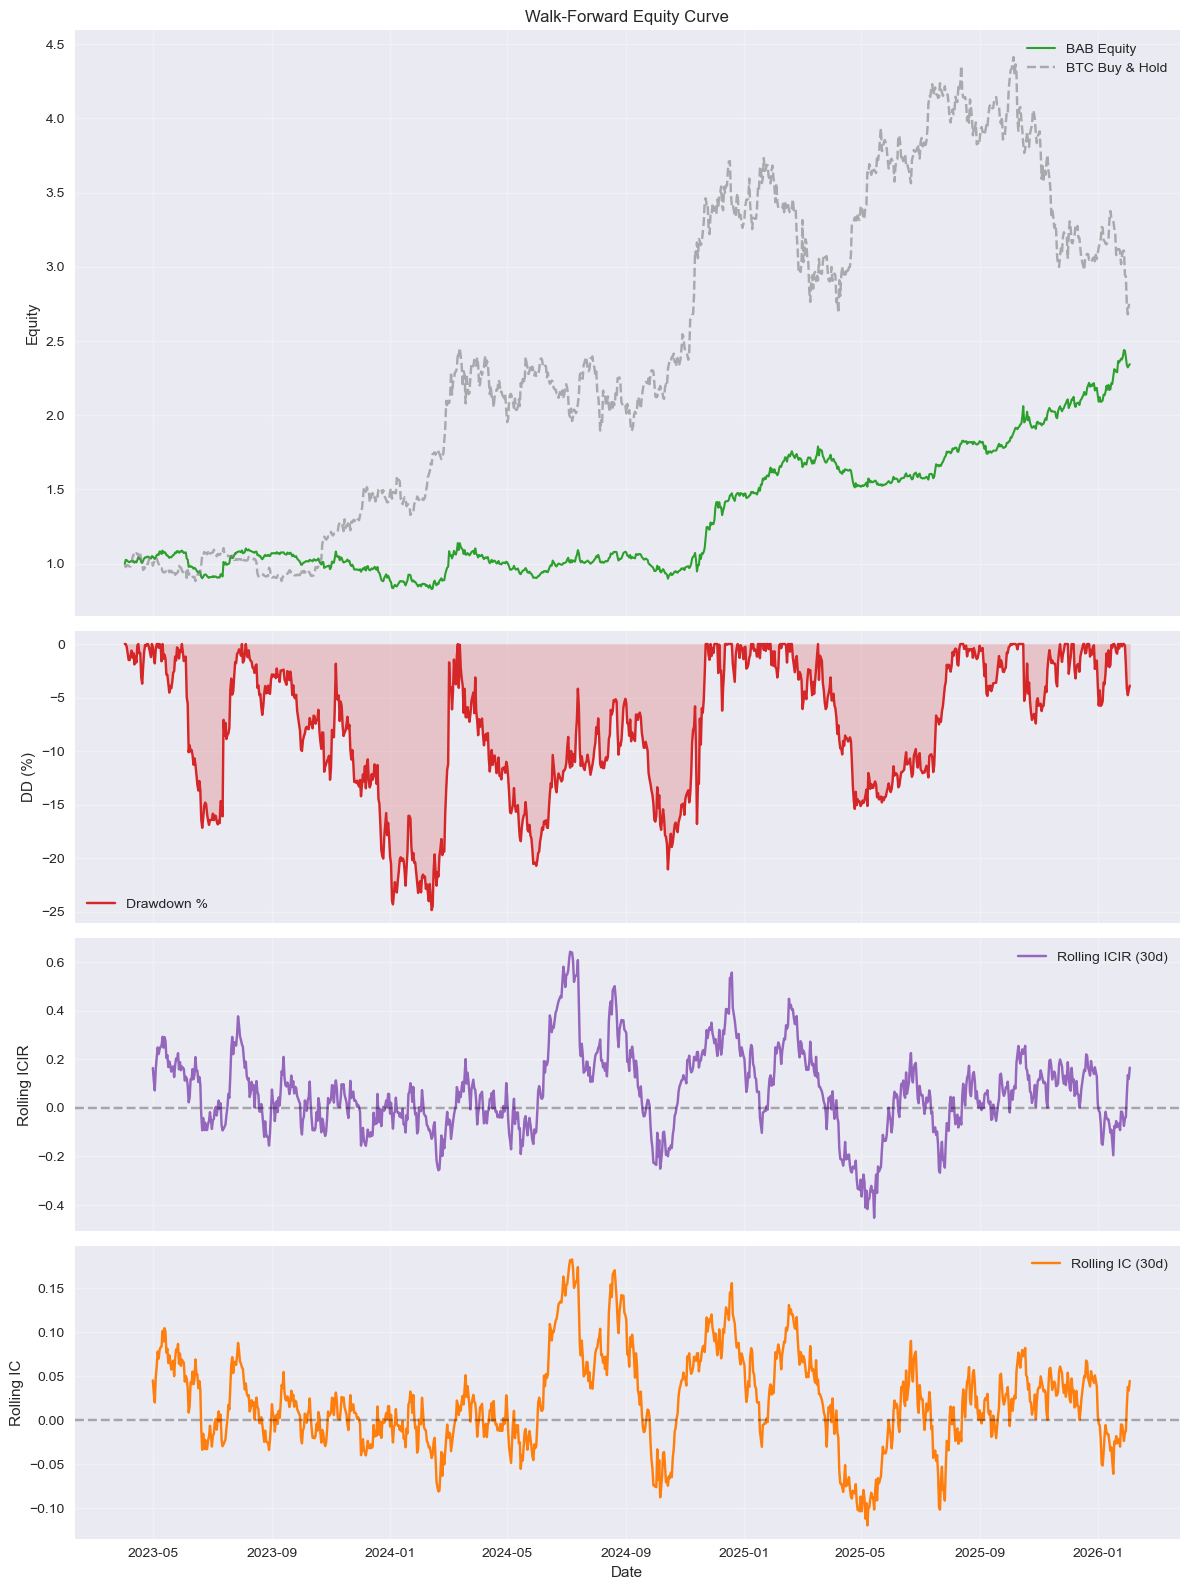

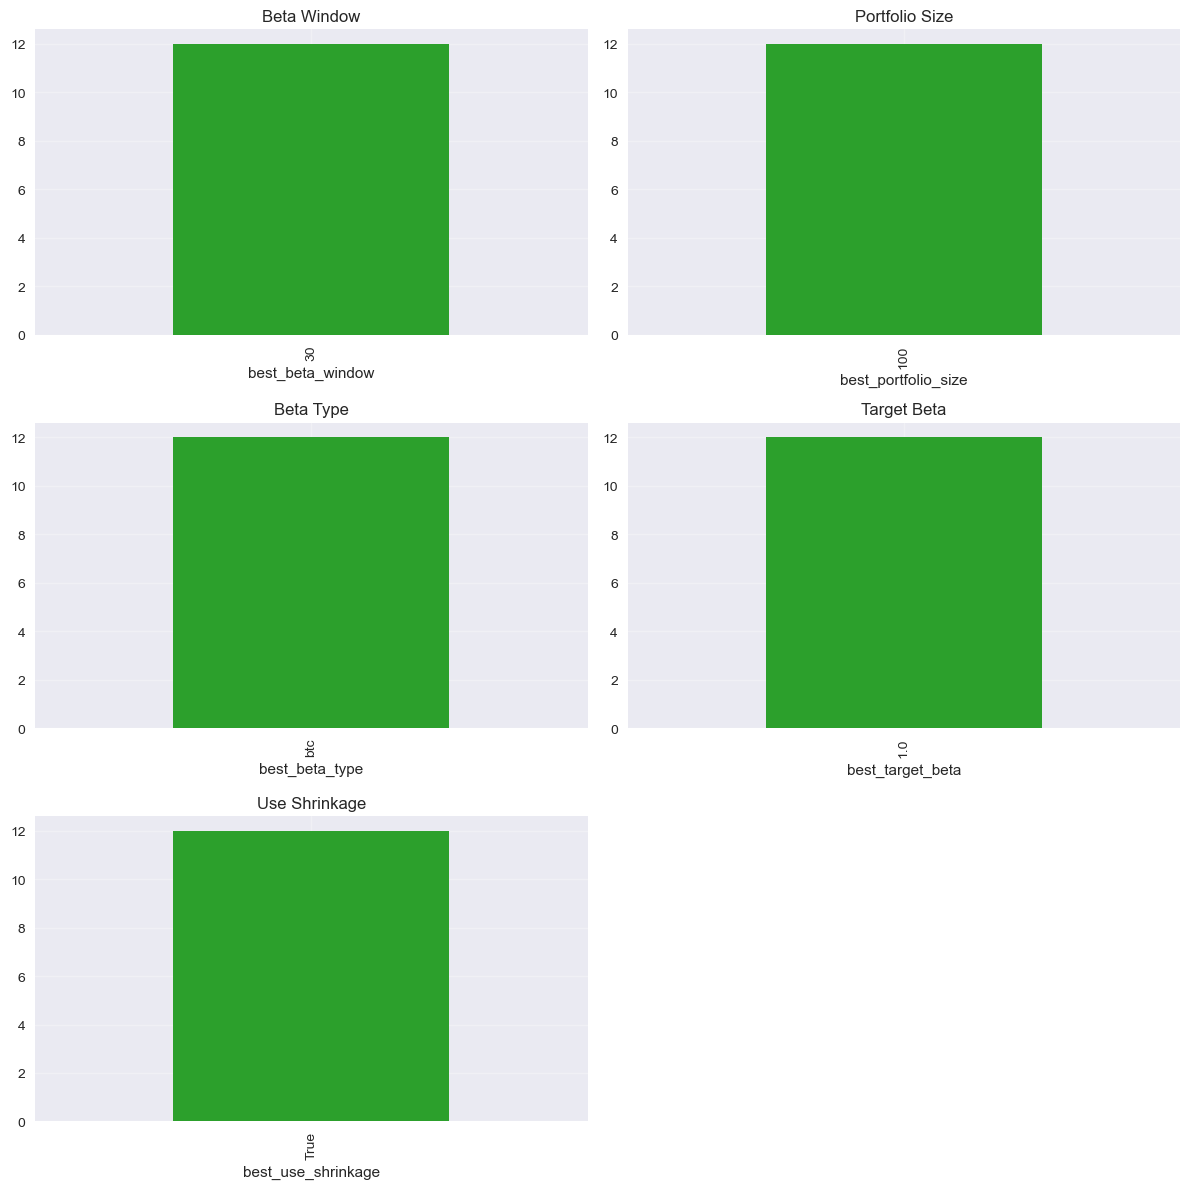

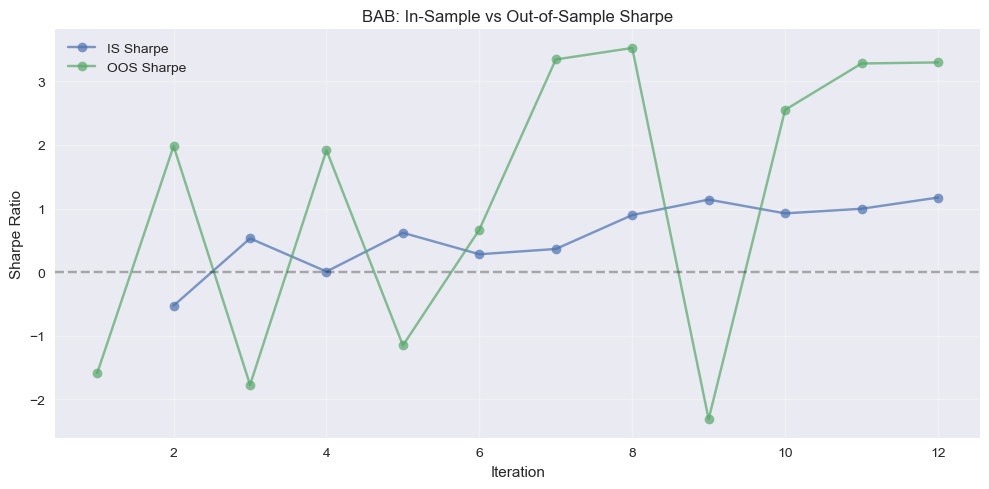

In [4]:
quintile_results = {}
quintile_returns = {}
quintile_stats = []

n_quintiles = 5

for q in range(n_quintiles):
    print(f"\nRunning BAB for Liquidity Quintile {q+1}/{n_quintiles} (Higher is more liquid)...")
    
    # Create a specialized Runner that uses our specific QuintileWeighting
    # Since BABWalkForwardRunner uses self.weighting_cls(), we'll wrap our class
    # to support no-arg instantiation with the captured 'q'.
    
    class SpecificQuintileWeighting(QuintileWeighting):
        def __init__(self):
            super().__init__(target_quintile=q, n_quintiles=n_quintiles)
            
    runner = BABWalkForwardRunner(
        bundle=bundle,
        params_grid=[base_params], # Pass single param object
        train_span=90,
        test_span=90,
        step_span=90,
        score_mode="sharpe",
        mode='expanding'
    )
    
    # Inject our custom weighting class
    runner.weighting_cls = SpecificQuintileWeighting
    
    # Run
    wf_df, oos_returns, oos_equity, oos_price_ret, oos_funding_ret, positions_df, detailed_df = runner.run()

    # Generate Full Report (Rolling IR, IC, ICIR, Plots)
    print(f"\n--- Report for Quintile {q+1} ---")
    rep = runner.report(
        wf_df=wf_df,
        oos_returns=oos_returns,
        oos_equity=oos_equity,
        oos_price_returns=oos_price_ret,
        oos_funding_returns=oos_funding_ret,
        detailed_df=detailed_df,
        plot=False,
        fig_dir="/Users/chinjieheng/Documents/research/BAB/figures_bab/quintiles",
        title_suffix=f"Quintile {q+1}"
    )
    
    
    # Generate Full Report (Rolling IR, IC, ICIR, Plots)
    print(f"\n--- Report for Quintile {q+1} ---")
    rep = runner.report(
        wf_df=wf_df,
        oos_returns=oos_returns,
        oos_equity=oos_equity,
        oos_price_returns=oos_price_ret,
        oos_funding_returns=oos_funding_ret,
        detailed_df=detailed_df,
        plot=True
    )
    
    # Store results
    quintile_results[q] = oos_equity
    quintile_returns[q] = oos_returns
    
    # Compute stats
    sharpe = compute_sharpe(oos_returns)
    total_ret = (oos_equity.iloc[-1] - 1.0) if not oos_equity.empty else 0.0
    
    # Max Drawdown
    if not oos_equity.empty:
        running_max = oos_equity.expanding().max()
        dd = (oos_equity - running_max) / running_max
        max_dd = dd.min()
    else:
        max_dd = 0.0
        
    quintile_stats.append({
        "Quintile": q + 1,
        "Description": f"Q{q+1} (Lowest Vol)" if q == 0 else (f"Q{q+1} (Highest Vol)" if q == n_quintiles-1 else f"Q{q+1}"),
        "Sharpe": sharpe,
        "Total Return": total_ret,
        "Max Drawdown": max_dd
    })

stats_df = pd.DataFrame(quintile_stats)

# Analyze and Compare Performance Metrics
Aggregate key metrics (Sharpe ratio, Annualized Return, Max Drawdown) from the varying quintiles into a summary DataFrame to compare performance across different liquidity profiles.

=== Performance by Liquidity Quintile ===


,Quintile,Description,Sharpe,Total Return,Max Drawdown
0,1,Q1 (Lowest Vol),0.53,94.20%,-30.65%
1,2,Q2,-1.28,-58.38%,-60.73%
2,3,Q3,-0.11,-18.74%,-47.84%
3,4,Q4,0.74,83.09%,-50.44%
4,5,Q5 (Highest Vol),1.21,134.43%,-24.86%


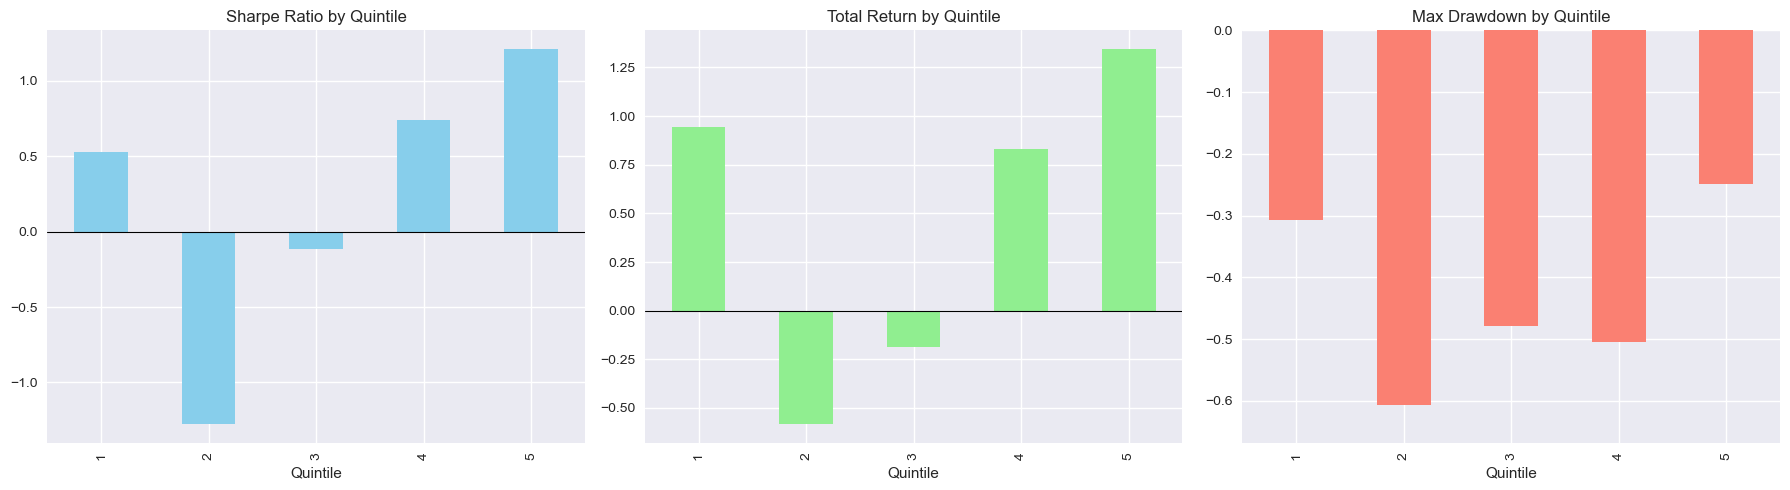

In [5]:
print("=== Performance by Liquidity Quintile ===")
# Format columns
display_cols = ["Quintile", "Description", "Sharpe", "Total Return", "Max Drawdown"]
styled_stats = stats_df[display_cols].style.format({
    "Sharpe": "{:.2f}",
    "Total Return": "{:.2%}",
    "Max Drawdown": "{:.2%}"
})
display(styled_stats)

# Plot Metrics Bar Chart
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

stats_df.plot(x="Quintile", y="Sharpe", kind="bar", ax=axes[0], color="skyblue", legend=False)
axes[0].set_title("Sharpe Ratio by Quintile")
axes[0].axhline(0, color='black', linewidth=0.8)

stats_df.plot(x="Quintile", y="Total Return", kind="bar", ax=axes[1], color="lightgreen", legend=False)
axes[1].set_title("Total Return by Quintile")
axes[1].axhline(0, color='black', linewidth=0.8)

stats_df.plot(x="Quintile", y="Max Drawdown", kind="bar", ax=axes[2], color="salmon", legend=False)
axes[2].set_title("Max Drawdown by Quintile")
axes[2].set_ylim(bottom=stats_df["Max Drawdown"].min() * 1.1, top=0) # Inverted for DD

plt.tight_layout()
plt.show()

# Visualize Cumulative Returns by Quintile
Generate a plot comparing the cumulative returns of the lowest volume quintile versus the highest volume quintile and others to visualize liquidity impact.

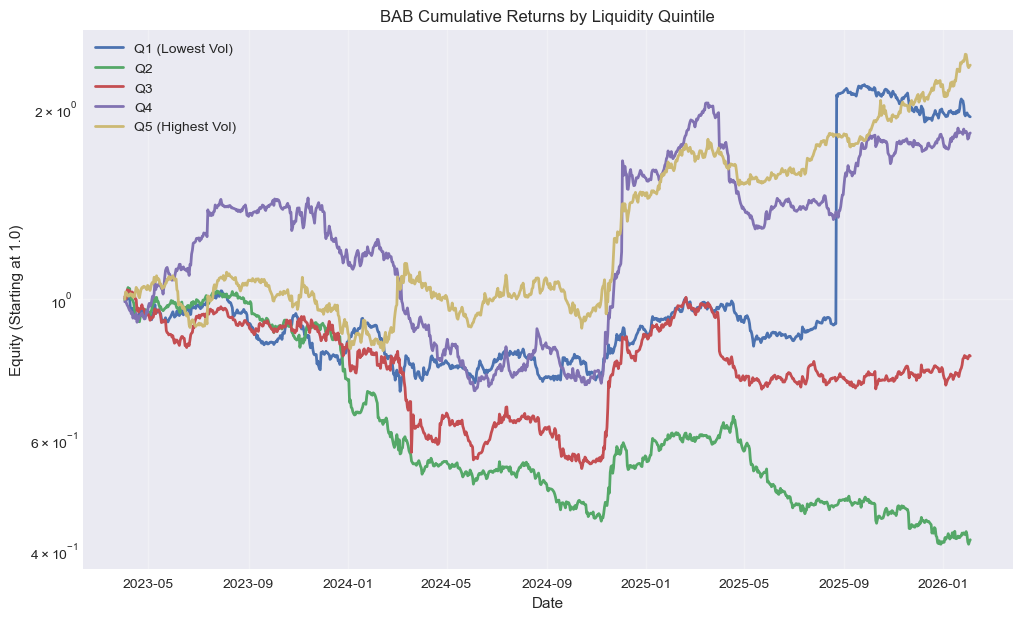

In [6]:
plt.figure(figsize=(12, 7))

for q, equity in quintile_results.items():
    if not equity.empty:
        label = f"Q{q+1} (Lowest Vol)" if q == 0 else (f"Q{q+1} (Highest Vol)" if q == n_quintiles-1 else f"Q{q+1}")
        plt.plot(equity.index, equity, label=label, linewidth=2)

plt.title("BAB Cumulative Returns by Liquidity Quintile")
plt.xlabel("Date")
plt.ylabel("Equity (Starting at 1.0)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log') # Log scale is often better for equity curves
plt.show()